In [12]:
import json

import regex
from tqdm import tqdm
from scipy import sparse

In [13]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
responses = []
with open('banki_responses.json', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:39, 5026.51it/s]


#  Домашнее задание по NLP # 2 [100 баллов] 
## Составление словарей для классификации по тональности
При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.  

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).


Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

In [5]:
responses[100]

{'city': 'г. Кострома',
 'rating_not_checked': False,
 'title': 'Как быстро данные о погашении кредита передаются в БКИ?',
 'num_comments': 4,
 'bank_license': 'лицензия № 3349',
 'author': 'Natlion',
 'bank_name': 'Россельхозбанк',
 'datetime': '2015-06-03 21:29:27',
 'text': 'Здравствуйте, Уважаемые сотрудники банка! В декабре 2014 года я взяла потребительский кредит, 26.05.2015 года досрочно его погасила. На данный момент пытаюсь оформить ипотеку в другом банке, но данные о погашении кредита не дошли до БКИ, справки о закрытии кредита не помогут, в банке сказали - ждать обновления кредитной истории для подачи заявки. В связи с этим хотелось бы узнать - как часто данные из Вашего банка передаются в БКИ? Ни в местных отделениях банка, ни по телефону горячей линии не смогли дать однозначного ответа, одни говорят- неделя, другие-две, третьи- месяц. В результате этого возник вопрос, потому как на квартиру, которую хочу приобрести, оформлена бронь, которая через две недели закончится и в 

## Часть 1. Обучение модели word2vec [50 баллов]

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова. 
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    * тест на определение ближайших слов
    * тест на аналогии (мужчина – король : женщина – королева)
    * тест на определение лишнего слова.
    
4. Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.  Более формально:
    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  
 


Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

In [6]:
len(responses)

153499

In [7]:
df = pd.DataFrame(responses)[['text']]

In [8]:
import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text)
    except:
        return ""


df['text'] = df.text.apply(lambda x: x.lower())
df['words_only'] = df.text.apply(words_only)

In [11]:
from nltk.corpus import stopwords
sw = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 'сч', 'хотя']

In [12]:
def remove_stopwords(text, mystopwords = sw):
    try:
        return [token for token in text if not token in mystopwords]
    except:
        return ""

In [13]:
df['words_only_without_sw']= df['words_only'].apply(remove_stopwords) 

In [14]:
from collections import Counter
def counter(how):
    cnt = Counter()
    n_types = []
    n_tokens = []
    tokens = []
    for index, row in tqdm(df.iterrows(), total = len(df)):
        tokens = row[how]
        cnt.update(tokens)
        n_types.append(len(cnt))
        n_tokens.append(sum(cnt.values()))
    for i in cnt.most_common(10):
        print(i)

In [15]:
counter('words_only_without_sw')

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [00:25<00:00, 5922.30it/s]


('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('очень', 66824)


In [16]:
from pymorphy2 import MorphAnalyzer

pm2 = MorphAnalyzer()


def lemmatize(text, mystem=pm2):
    try:
        return [pm2.parse(word)[0].normal_form for word in text]
    except:
        return " "

In [17]:
df['lemmas'] = df['words_only_without_sw'].apply(lemmatize) 

In [27]:
df.to_csv('df_lemmas.csv', encoding='utf-8', index=False)

In [47]:
df.head()

,text,words_only,words_only_without_sw,lemmas
0,добрый день! я не являюсь клиентом банка и пор...,"[добрый, день, я, не, являюсь, клиентом, банка...","[добрый, день, являюсь, клиентом, банка, поруч...","[добрый, день, являться, клиент, банка, поручи..."
1,доброго дня! являюсь держателем зарплатной кар...,"[доброго, дня, являюсь, держателем, зарплатной...","[доброго, дня, являюсь, держателем, зарплатной...","[добрый, день, являться, держатель, зарплатный..."
2,здравствуйте! дублирую свое заявление от 03.0...,"[здравствуйте, дублирую, свое, заявление, от, ...","[здравствуйте, дублирую, свое, заявление, можа...","[здравствовать, дублировать, свой, заявление, ..."
3,добрый день!! я открыл расчетный счет в сберба...,"[добрый, день, я, открыл, расчетный, счет, в, ...","[добрый, день, открыл, расчетный, счет, сберба...","[добрый, день, открыть, расчётный, счёт, сберб..."
4,"04.03.2015 г. взяла кредит в вашем банке, заяв...","[г, взяла, кредит, в, вашем, банке, заявленная...","[г, взяла, кредит, вашем, банке, заявленная, м...","[год, взять, кредит, ваш, банка, заявить, я, с..."


In [15]:
df = pd.read_csv('df_lemmas.csv', encoding='utf-8')

In [9]:
from gensim.models import Word2Vec

C:\Users\Arsenii\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [49]:
#%%time
model = Word2Vec(df.lemmas, size=100, window=3, min_count=20, workers=4)

In [ ]:
model.save("word2v.model")

In [10]:
model = Word2Vec.load("word2v.model")

C:\Users\Arsenii\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [95]:
model.most_similar("вклад")

[('депозит', 0.9553532600402832),
 ('смартвклад', 0.6522068977355957),
 ('депозитный', 0.6301376223564148),
 ('твклад', 0.6065186262130737),
 ('омс', 0.6027424335479736),
 ('капитализация', 0.5902348756790161),
 ('картсчёт', 0.567818820476532),
 ('доходный', 0.562853991985321),
 ('накопительный', 0.5545151233673096),
 ('скс', 0.5532351732254028)]

In [53]:
model.most_similar(positive=["процент","кредит"], negative=["вклад"])

[('неустойка', 0.6079773902893066),
 ('пенить', 0.5989506244659424),
 ('ссуда', 0.5940375328063965),
 ('пеня', 0.5872383117675781),
 ('штраф', 0.5788528919219971),
 ('рассрочка', 0.5592546463012695),
 ('пенни', 0.5529189109802246),
 ('автокредит', 0.5315576195716858),
 ('потребкредит', 0.5290640592575073),
 ('единовременно', 0.5241854786872864)]

In [54]:
model.doesnt_match("банк вклад клиент город".split())

'город'

In [55]:
model.doesnt_match("зарплата карта сотрудник вклад мир".split())

'сотрудник'

## Постройте несколько визуализаций:

- **TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов**

In [18]:
from nltk import FreqDist

In [19]:
top_words = []

fd = FreqDist()
for text in tqdm(df.lemmas):
    fd.update(text)
for i in fd.most_common(1000):
    top_words.append(i[0])

100%|█████████████████████████████████████████████████████████████████████████| 153499/153499 [02:38<00:00, 966.12it/s]


In [58]:
top_words_vec = model[top_words[:500]]

In [59]:
from sklearn.manifold import TSNE

In [60]:
tsne = TSNE(n_components=2, random_state=0)

top_words_tsne = tsne.fit_transform(top_words_vec)

In [61]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

- **Например, можно увидеть кластер с названиями месяцев.**
- **Кластер с "презензия, жалоба, заявление, отзыв, обращение, запрос" также является достаточно обособленным.** 
- **Также кластер с "смс, сообщение, уведомление, письмо, почта".**
- **И еще, например, "снять, снимать, снятие, забрать, положить, перевести, вносить, внести"**
- **И т.д.**

- **Задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.**

In [96]:
df_ = pd.DataFrame(responses)

In [104]:
df_['bank_name'].value_counts()[:10]

Сбербанк России              26327
Альфа-Банк                   10224
ВТБ 24                        8185
Русский Стандарт              7943
Хоум Кредит Банк              7549
Тинькофф Банк                 5387
Национальный Банк «Траст»     4607
Ренессанс Кредит              3849
Связной Банк                  3775
ОТП Банк                      3237
Name: bank_name, dtype: int64

## Возьмем первую десятку самых популярных банков. 

In [150]:
banks = ['сбербанк', 'альфа', 'втб', 'русский', 'хоум', 'тинькофф', 'траст', 'ренессанс', 'опт']

In [147]:
x = []
y = []
for bank in banks:
    print(bank)
    x.append((model['хороший'] - model['плохой']) @ model[bank])
    y.append((model['быстрый'] - model['медленный']) @ model[bank])

сбербанк
альфа
втб
русский
хоум
тинькофф
траст
ренессанс
опт


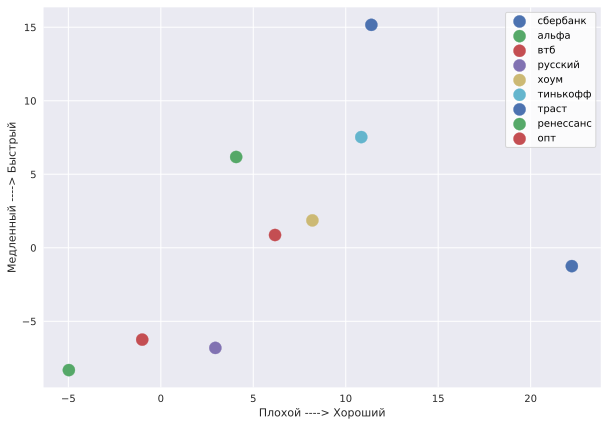

In [173]:
%config InlineBackend.figure_format = 'svg'

with plt.style.context('seaborn'):
    plt.figure(figsize=(10,7))
    for i in range(len(x)):
        plt.scatter(x[i], y[i], s=150)
        
plt.xlabel('Плохой ----> Хороший')
plt.ylabel('Медленный ----> Быстрый')
plt.legend(banks)

## Таким образом, Сбербанк лидирует, а Ренессанс банк наихудший в нашем пространстве.